# INTRO

---


For this notebook, my objective is to apply the knowledge I acquired in building convolutional neural networks. 
I chose the EuroSAT dataset from Kaggle (https://www.kaggle.com/datasets/ryanholbrook/eurosat). 

This dataset has a total of 27,000 labeled images taken by the Sentinel-2 satellite. The labels represent the land use of each of the image. 

The notebook is divided into the following sections: 

1. Importing libraries
2. Fetching and Exploring the data
3. Building the input pipeline (including preprocessing)
4. Optimising data access 
5. Augmenting the data 
6. Building, training and testing the CNN model
7. What  <font color = 'red'>**SURPRISED ME!!** </font> 🤯🤯🤯🤯🤯 😮😮😮😮😮😮😮

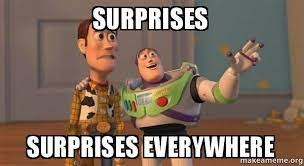

## 1. Importing libraries

---



In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import json
import pprint
import datetime

## 2. Fetching and exploring the data

---




Let us see what files we have in the dataset folder


In [2]:
path = 'archive (1)/eurosat/rgb/2.0.0'
os.listdir(path)

['dataset_info.json',
 'eurosat-train.tfrecord-00000-of-00001',
 'image.image.json',
 'label.labels.txt']

Let us start by reading the dataset_info.json file

In [3]:
json_path = os.path.join(path, 'dataset_info.json')
with open(json_path,'r') as json_file:
  data = json.load(json_file)
pprint.pprint(data)

{'citation': '@misc{helber2017eurosat,\n'
             '    title={EuroSAT: A Novel Dataset and Deep Learning Benchmark '
             'for Land Use and Land Cover Classification},\n'
             '    author={Patrick Helber and Benjamin Bischke and Andreas '
             'Dengel and Damian Borth},\n'
             '    year={2017},\n'
             '    eprint={1709.00029},\n'
             '    archivePrefix={arXiv},\n'
             '    primaryClass={cs.CV}\n'
             '}',
 'description': 'EuroSAT dataset is based on Sentinel-2 satellite images '
                'covering 13 spectral\n'
                'bands and consisting of 10 classes with 27000 labeled and\n'
                'geo-referenced samples.\n'
                '\n'
                'Two datasets are offered:\n'
                '- rgb: Contains only the optical R, G, B frequency bands '
                'encoded as JPEG image.\n'
                '- all: Contains all 13 bands in the original value range '
                '

* The 'description' key tells us there are 27,000 labeled images and 10 classes. The dataset exists in RGB frequency bands or all 13 bands. Lets use the RGB frequency bands. 
* The 'schema' key shows us that the images are 64x64x3 and the label is an integer. 

Okay, now let us check out our data in  'eurosat-train.tfrecord-00000-of-00001' 

Let us see what classes we have

In [4]:
#get the path where the data is saved
tfRec_data_path = os.path.join(path,'eurosat-train.tfrecord-00000-of-00001') 
#load the data 
tfrecord_dataset = tf.data.TFRecordDataset(tfRec_data_path) 
#let us look at one entry to see how we can extract the revelant data for our challenge
for serialized_example in tfrecord_dataset.take(1): 
    print(serialized_example.numpy())


b'\n\xad\n\n\x0e\n\x05label\x12\x05\x1a\x03\n\x01\t\n\xf8\t\n\x05image\x12\xee\t\n\xeb\t\n\xe8\t\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\xff\xdb\x00C\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\xff\xc0\x00\x11\x08\x00@\x00@\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x17\x00\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x02\n\xff\xc4\x00(\x10\x00\x02\x01\x04\x02\x02\x01\x04\x02\x03\x00\x00\x00\x00\x00\x00\x01\x11!\x001AQaq\x81\x91\xa1\x12\xb1\xe1\x

Not comprehensible 😖!

This indicates that our data is stored as byte strings. I will use the Example class to read the data. 

In [5]:
for serialized_example in tfrecord_dataset.take(1): 
    #create an example instance to allow us to read tfrecord data
    example = tf.train.Example()
    #now use the ParseFromString method
    example.ParseFromString(serialized_example.numpy())
    print(example)

features {
  feature {
    key: "label"
    value {
      int64_list {
        value: 9
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\377\333\000C\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\377\300\000\021\010\000@\000@\003\001\"\000\002\021\001\003\021\001\377\304\000\027\000\001\001\001\001\000\000\000\000\000\000\000\000\000\000\000\000\001\000\002\n\377\304\000(\020\000\002\001\004\002\

Now that is something a human can read 👍! 
Okay, let us now extract the data we need. They are stored in the feature dictionary with keys 'image' and 'label'. We can also get from the 'filename' key the class name that corresponds to the integer label. To extract our data from a tfRecord we need to specify the structure and data type of the features we are after (the images and the labels)
:



In [6]:
# we need a fixed length feature of type string for our images and a fixed length feature of type integer for our labels
features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'filename': tf.io.FixedLenFeature([], tf.string),
    }

Before i build the input pipeline, let me check the class names out of curiousity. These are the ones corresponding to the image labels (saved as integers)

In [7]:
#Let us get the path where the classes are saved
labels_path = os.path.join(path, 'label.labels.txt')
#these will be saved in byte string format. So let us use the appropriate method from tf.io and decode them. 
labels = ((tf.io.read_file(labels_path)).numpy()).decode('utf-8')
# labels = labels.split()
print(labels)

AnnualCrop
Forest
HerbaceousVegetation
Highway
Industrial
Pasture
PermanentCrop
Residential
River
SeaLake



Ah interesting 😎. Before i get too excited 😀 and start plotting to see these images, let me build the input pipeline first! 

## 3.Building the pipeline

---



In [8]:
def input_pipeline(tf_record):
  '''Extracts the data we need from each tf record
  Arguments
  =========
  tf_record: a serialized example from a TFRecord file
  
  Returns
  =======
  (image,label): a tuple with the image (64x64x3 float array) and its label (integer)'''

  #lets start by parsing the tf_record using the feature structure we defined earlier
  raw_record = tf.io.parse_single_example(tf_record, features)
  #let us grab the image
  image = raw_record['image']
  #now let us decode it as a jpeg (description file mentioned that the images are jpegs)
  image = tf.image.decode_jpeg(image)
  #lets rescale so our model does not experience any hickups
  image = tf.keras.layers.Rescaling(1/255.0)(image)
  #finally let us grab our label which is stored as an integer. so no decoding required
  label = (raw_record['label'])
  filename = (raw_record['filename'])
  return (image, label,filename)


Alright❗ Our input_pipeline is ready. We can now map it to each tfrecord and have our dataset ready for our CNN!! EXCITING 😃! 

In [9]:
new_tf= tfrecord_dataset.map(input_pipeline)



The description file mentioned that there are 27,000 images.Emm.. I do not trust them.. I'd better investigate 🤔! 


In [10]:
num_records = 0
for element in tfrecord_dataset:
  num_records = num_records+1
print(num_records)

27000


Okay, it is legit. I will take off my sherlock hat for now! 

Let us look at on image representing each of the 10 classes. 

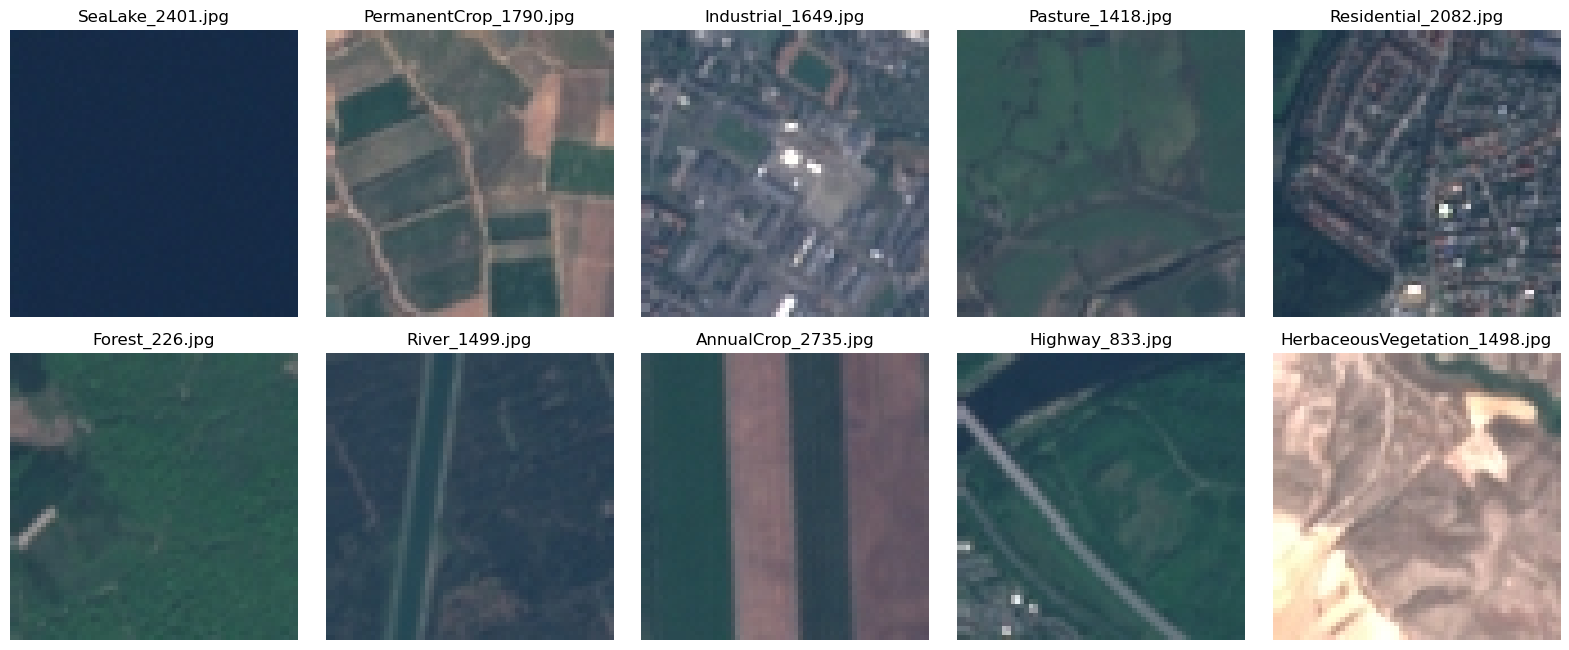

In [11]:
#define an empty set that will be appended everytime an image with a new landuse is plotted. We will stop the plotting loop once all 10 landuses are plotted
plotted = []
#define subplot for 10 images representing 10 unique landuses
figure, ax = plt.subplots(2,5, figsize = (20,8))
ax = ax.flatten()
figure.subplots_adjust(wspace = 0.1,hspace = 0.1)

i_fig = 0
#let us loop over 100 examples hoping they will contain at least one image of each of the 10 landuses
for example in new_tf.take(100):
  #take one image example from the batch. Use '.numpy()' to extract the image value. It will be an array of floats. 
  sample_image = example[0].numpy()
  if example[1].numpy() not in plotted:
    ax[i_fig].imshow(sample_image)
    #remove axis as it is irrelevant and for aesthetics
    ax[i_fig].axis('off')
    #set the title of the image using its filename - which also includes its label/landuse
    ax[i_fig].set_title(example[2].numpy().decode('utf-8'))
    i_fig +=1
    #append the plotted list
    plotted.append(example[1].numpy())
  #if we already came across all 10 classes let us break the loop
  if len(plotted) == 10:
    break





  

THe new_tf currently has the following format: (input, label, filename). The ML model expects data in the following format(input, label). 

Now that we have have seen images of each label, we do not need filename anymore. So i will delete it so it does not create an error. 

In [12]:
def remove_third_element(a,b,c):
    return a,b

# Map the dataset to remove the third elements
new_tf = new_tf.map(remove_third_element)

Now let us split our record data into train, validation and testing data. 
I will go with 80% for training, 10% for validation and testing respectively. 

In [13]:
training_percentage = 0.8
val_test_percentage = 0.1
train_examples = int(num_records*training_percentage) 
val_examples = int(num_records*val_test_percentage)
test_examples = num_records-train_examples-val_examples

Use the number of examples to split the tfrecords into our training, validation and testing datasets

In [14]:
train_tf = new_tf.take(train_examples)
val_tf = new_tf.skip(train_examples).take(val_examples)
test_tf = new_tf.skip(train_examples+val_examples).take(test_examples)

## 4. Optimising data access

---



Our models will need access to chunks of data as they train, validate and test over batches and epochs. To improve performance by reducing memory latency and increasing data access speed. We will use cache and prefetching. What is that you may ask! 😕🤔🤌 (italian gesture to signal confusion). 

 Imagine you are making lemonade 🍋🍋🍋🍋🍋🍋🍋. 

 Everytime you want to make a new glass, you have to go to the storage, ⏭️ bring few lemons⏭️ and prepare lemonde. 
 
 Well, if you get a lot of clients, you will waste a lot of time going back and forth between storage and the booth. 😫😫😫😫😫😫
 
 To reduce the time and effort this process takes, you would always have a sack of lemons in the cupboard near you **(that is cache)** and you would hire someone to keep an eye 👀👀 on the sack and as it is getting consumed immediately goes to storage 🏃, fetches a sack of lemon 🍋 and leave it near you for when you need it **(that is prefetch)**. 

Let's help our model by caching and prefetching our datasets

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_tf = train_tf.cache().prefetch(buffer_size = AUTOTUNE)
val_tf = val_tf.cache().prefetch(buffer_size = AUTOTUNE)
test_tf = test_tf.cache().prefetch(buffer_size = AUTOTUNE)

Now let us cut our three datasets into batches. Splitting large datasets into batches has a lot of advantages. Ask ChatGPT and you have a good idea. Let's do it! 

In [16]:
BATCH_SIZE = 32
train_tf = train_tf.batch(BATCH_SIZE)
test_tf = test_tf.batch(BATCH_SIZE)
val_tf = val_tf.batch(BATCH_SIZE)


We are getting close to build our model, but not just yet !!!

![picture](https://media.makeameme.org/created/suspense-why.jpg)

## 5. Augmenting the data 

---



As you may know, overfitting is one of ML models' biggest challenges. Imagine you join a bootcamp wher you are taught to design keys for only three types of locks. You spend hours and hours and master how to design keys 🗝️ for these specific locks 🔒! 

Then you get thrown into the outside world 🌍. People come to you with all different types of locks. You just can't figure it out because you did not learn the general mechanics of how keys and locks function. You just learned how to design keys for three types of locks. This is overfitting. 

To remedy that for neural networks we use data augmentation. Data augmentation is useful when we have small datasets. It applies various techniques to generate new data from the existing data.
In the computer vision domain, this translates into transforming images by using rotation, zoon, crop, horizontal/vertical flips to generate new images. 

The generated images, albeit from existing images, will seem 'new' to our ML model. This will allow it to identify the correct patterns that will allow it to better generalize to 'true' new images. 

In [17]:
# As i intend to use augement as a layer in my ML model, i will create it as a class. 
# Augment will create 4 images out of each image input. One with rotation, the other with zoom, another with horizontal & vertical flip and finally cropped. 
class Augment(tf.keras.layers.Layer):
  def __init__(self): 
    # allow the class to inherit all  methods and properties of a keras layer (given as argument above)
    super().__init__()
    # define all the methods that will be good on instantiation
    self.rotate = tf.keras.layers.RandomRotation(0.3)
    self.zoom = tf.keras.layers.RandomZoom(0.2)
    self.flip = tf.keras.layers.RandomFlip(mode = 'horizontal_and_vertical')
    self.crop = tf.keras.layers.RandomCrop(54,54)

  # use a call method so that it is called automatically everytime Augment is called with an input argument
  def call(self,input):
    input = self.rotate(input)
    input = self.zoom(input)
    input = self.flip(input)
    input = self.crop(input)
    return input


Let us have a look at how images will be transformed after passing through an Augment layer! 

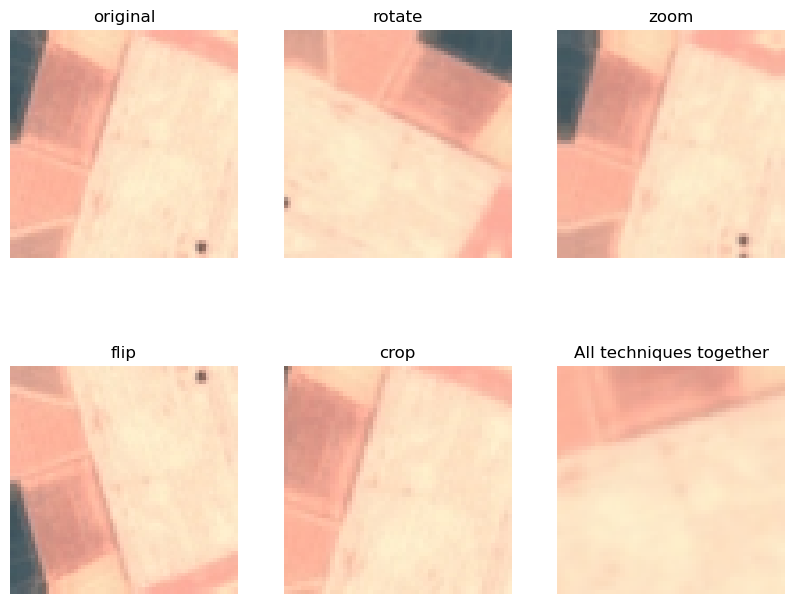

In [18]:
#take one batch of the training dataset
for batch in train_tf.take(1):
  #take one image example from the batch. Use '.numpy()' to extract the image value. It will be an array of floats. 
  sample_image = batch[0][23].numpy()

#instantiate an Augment layer
augment_layer = Augment()

#extract all the methods of the augment_layer. We will be using one by one to see their effect on our sample image. 
augment_methods = ['original', augment_layer.rotate, augment_layer.zoom, augment_layer.flip, augment_layer.crop,augment_layer]
#for each method, provide a name that represents what it is doing to the image. This will be used as title when we plot our sample image and the generated ones. 
image_titles = ['original', 'rotate','zoom','flip','crop', 'All techniques together']

 # how many images will we get: we want to see the output of each augmentation layer + the sample image + the output of the sample image going through all augmentation layers
num_images_2_display = len(augment_methods)
#Let our subplot have two rows
n_rows = 2
# let us calculate the number of columns using the total number of images we are expecting and the number of rows
n_cols = int(np.ceil(num_images_2_display/n_rows))

#define our figure and its handle
figure, ax = plt.subplots(n_rows,n_cols, figsize = (10,8))
#flatten the handle 
ax = ax.flatten()
for i in range(num_images_2_display):
  # start by plotting our sample image
  if augment_methods[i]=='original':
    ax[i].imshow(sample_image)
    ax[i].axis('off')
    ax[i].set_title(image_titles[i])
  else:
    #plot the output of each method
    ax[i].imshow(augment_methods[i](sample_image))
    ax[i].axis('off')
    ax[i].set_title(image_titles[i])


For each image in our training dataset, we now have generated 4 additional images (roate, zoom, flip and crop)! 

## 6. Building, training and testing the model

WE ARE FINALY HERE!!! TIME FOR THE COOL MAGIC SH*T!!!! 

![picture](https://media.makeameme.org/created/there-is-so-5bd93e.jpg)

I did several iteration to reach the architecture below: 

* I started with one Conv2D layer, GlobalAveragePooling2D and one Dense layer and worked my way up. 
* Conv2D layers are working to capture the patterns in the images. I'll show you examples of these patterns later. 
* Dropout layer are contributing to prevent overfitting. This is by randomly dropping 20% of each Conv2D's filters. 
* MaxPool serves to extract the most salient features and to downsample the images. 
* GlobalAveragePooling2D reshapes the output of the last MaxPoolLayer so it can be accepted by the Dense layers. 
* Dense layers or fully connected layers are learning complex non-linear mappings and capture global patterns by combining the local features learned by the Conv2D layers.

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = [54,54,3]),
    Augment(),
    tf.keras.layers.Conv2D(32,3, activation = 'relu'),
    tf.keras.layers.Conv2D(32,3, activation = 'relu'),
    tf.keras.layers.Conv2D(32,3, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32,3, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(512,3, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(32, kernel_regularizer =tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(32, kernel_regularizer =tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(10)
])

Let us define a callback that stops training when the validation accuracy stops improving after 10 epochs! 
Let us also store training information so we can use it in a tensorboard later. 

In [20]:
#define the path where we want to store the information from each training epoch
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#define the callback function that will monitor validation accuracy, stop training if it does not improve within 10 epochs, and restore the best weights, i.e. the weights that got us the higher validation accuracy
def get_callbacks():
  return [tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',patience = 10,restore_best_weights= True),
          tf.keras.callbacks.TensorBoard(log_dir =log_dir)]

Let us also create a checkpoint to save the best weights to an h5 file so we can open them for later use

In [21]:
checkpoint = ModelCheckpoint('model_weights.h5', monitor = 'val_accuracy', save_best_only = True, mode = 'max')

Let us compile the model by choosing an optimizer, a loss fucntion and the metrics to be used to evaluate the model's performance. 

In [22]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(), loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

In [23]:
history = model.fit(train_tf, epochs = 30, validation_data=val_tf, callbacks = [get_callbacks(), checkpoint])

Epoch 1/30
675/675 [==============================] - 75s 109ms/step - loss: 1.6573 - accuracy: 0.3851 - val_loss: 1.2696 - val_accuracy: 0.5970
Epoch 2/30
675/675 [==============================] - 77s 114ms/step - loss: 1.1307 - accuracy: 0.6135 - val_loss: 1.0347 - val_accuracy: 0.6967
Epoch 3/30
675/675 [==============================] - 79s 117ms/step - loss: 0.9405 - accuracy: 0.6824 - val_loss: 0.8214 - val_accuracy: 0.7674
Epoch 4/30
675/675 [==============================] - 77s 115ms/step - loss: 0.8395 - accuracy: 0.7146 - val_loss: 0.9224 - val_accuracy: 0.6811
Epoch 5/30
675/675 [==============================] - 81s 121ms/step - loss: 0.7643 - accuracy: 0.7439 - val_loss: 0.7293 - val_accuracy: 0.7581
Epoch 6/30
675/675 [==============================] - 76s 112ms/step - loss: 0.7066 - accuracy: 0.7638 - val_loss: 0.7145 - val_accuracy: 0.7678
Epoch 7/30
675/675 [==============================] - 94s 140ms/step - loss: 0.6607 - accuracy: 0.7804 - val_loss: 0.6230 - val_ac

Let us plot the training and validation accuracy to check our model's performance

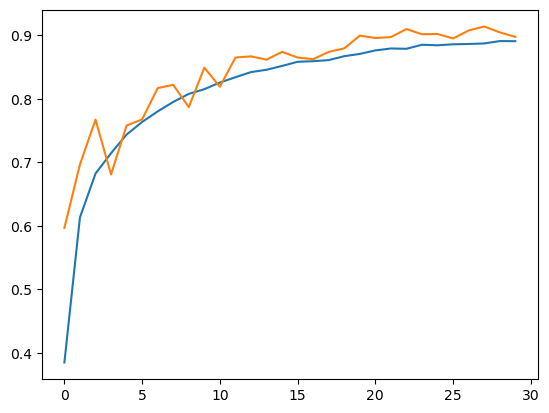

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

It took me lots of iterations reviewing the model architecture and the hyperparameters to get there. At this stage and for the purpose of this notebook, I would say it is a satisfactory result. Accurayc is near 90% and the validaiton accuracy is at similar level of training accuracy. Validation is looking pretty choppy and is worth future investigation to smooth it out.

Let's evalute the model's accuracy on the test data

In [25]:
model.evaluate(test_tf)   

85/85 [==============================] - 3s 29ms/step - loss: 0.3675 - accuracy: 0.8848


[0.36753565073013306, 0.8848147988319397]

This is not bad. However, in the context of land use identification, it needs further improvement. A human being is probably capable of achieving 100% accuracy on these images. So 88% is not good enough for this model to be deployed yet! 

Now let us see what local features these Cov2D layers are learning. 

1/1 [==============================] - 0s 24ms/step


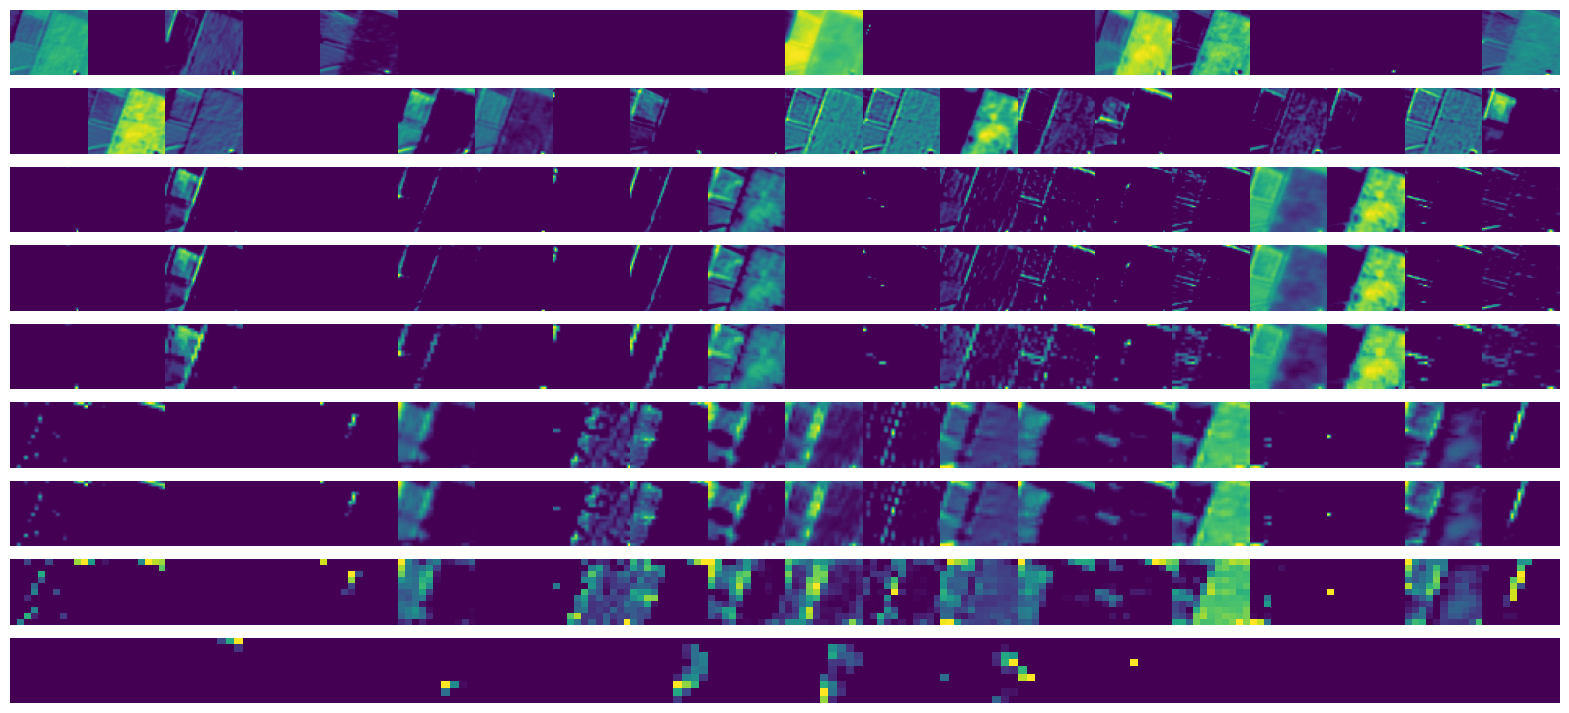

In [26]:
#grab all the layers of our model
model_layers = model.layers
# grab the output of each layer
output_layers = [layer.output for layer in model_layers[1:]] #dont want to include the Augment layer
#define a model that receives the model's input and gives back the outputs of each single layer
activation_model = tf.keras.Model(inputs = model.input, outputs = output_layers)
#there are a lot of filters in each conv2D layer, we cannot see them all on the screen. so let us just use a subset
num_filters = 20
#define our plot
figure, axes = plt.subplots(9,num_filters, figsize = (20,9))
#adjust the space between the subplots of each row and each column
figure.subplots_adjust(wspace = 0,hspace = 0.2)

axes = axes.flatten()
sample_image = tf.image.resize(sample_image,(54,54))
for j in range(9):
    #run the sample image through the model and pick the output corresponding to the jth layer
    f1 = activation_model.predict(sample_image[tf.newaxis,...])[j]
    #loop over all the filters to plot their respective outputs
    for i in range(num_filters):
        #grab the handle that corresponds to the jth layer and the ith filter    
        ax = axes[i+(j)*num_filters]
        #for each layer, grab the ith output of the ith filter. the ':,:' correspond to the image size of the output of each layer. It changes from layer to another as it undergoes maxPooling.
        # use color virdis so that the identified features light up like radioactive material! 
        ax.imshow(f1[0,:,:,i],aspect='auto', cmap='viridis')
        ax.set_axis_off()

This is a very exciting part for me. I love seeing what the 'computer' is learning. What features are lighting up in each Conv2D layer. I find this fascinating as it breaks down the learning into steps. This gives me insights of how my brain functions. 
We unconsciously look at images and identify their use. But we do not know what is happening in our brains. Maybe it is something similar to what the Conv2D layers are showing us. One neuron learns the straight edges that of agriculture land plots. Another neuron sees the big homogeneous parts which represent crops and fields. All this is so fascinating! 

## 7. What  <font color = 'red'>**SURPRISED ME!!** </font>


*   When I started building the model architecture, I thought the best way is to start with a conv2D with 8 filters and build my up level by level, i.e. 8,16,32,64,etc..However, i noticed that it could help to jump levels. For example, starting with 32 was better than starting with 8. Having two Conv2D with 32 filters each was also benefecial. Also, jumping from 32 to 512 lead to a much better accuracy than 32, 64, 128,etc.
*   The choice of optimizer. I started with Adam and just took it for granted. I reached a validation accuracy plateau with tweaking the model architecture and I was started to get frustrated. So I thought why not try changing the optimizer. Using RMSprop instead of Adam as optimizer lead to 10% increase in validation accuracy!!!!! I WAS SO HAPPY  when that happenned!! 
 



That is my first Kaggle project using what I have been learning for months on CNNs. It really feels great to be able to build models that can undertake real world tasks. I will now jump to text. I hope you enjoyed going through my notebook and maybe learned a few things or at least had a small giggle. Please reach out if you have any questions.

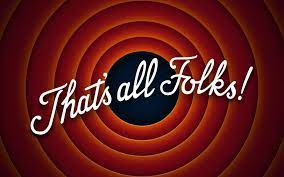